# Wymagane biblioteki

In [70]:
import numpy as np  # Obsługa tablic i operacji matematycznych
import matplotlib.pyplot as plt  # Wyświetlanie obrazów i wykresów

# Funkcje morfologiczne z biblioteki skimage
from skimage.morphology import (binary_dilation, binary_erosion,
                                 binary_opening, binary_closing,
                                 skeletonize, convex_hull_image,
                                 thin, disk, label)

from skimage.measure import regionprops
from skimage.segmentation import find_boundaries  # Detekcja granic obiektów
from skimage.util import invert # Negacja (odwrócenie) obrazu binarnego
from skimage.data import binary_blobs, cells3d, coins  # Generowanie przykładowych obrazów binarnych
from skimage.exposure import equalize_hist, adjust_gamma
from scipy.ndimage import distance_transform_edt  # Transformata odległościowa (Euclidean Distance Transform)
from skimage.filters import threshold_minimum, threshold_otsu, try_all_threshold


In [71]:
def show_image(image, title=None):
    plt.imshow(image, "gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [72]:
def show_row(images, labels):
    _, axs = plt.subplots(1, len(images), figsize=(6*len(images)*(len(images[0])/len(images[0][0])), 6*(len(images[0][0])/len(images[0]))))

    for i, ax in enumerate(axs):
        ax.imshow(images[i], "gray")
        ax.set_title(labels[i])
        ax.axis("off")
    
    plt.show()

In [73]:
def show_matrix(images, labels):
    _, axes = plt.subplots(len(images), len(images[0]), figsize=(6*len(images), 3*(len(images[0]))))

    for j in range(len(images)):
        for i in range(len(images[0])):
            axes[j, i].imshow(images[j][i], "gray")
            axes[j, i].set_title(labels[j][i])
            axes[j, i].axis("off")
    
    plt.show()

# 1. Obraz binarny testowy

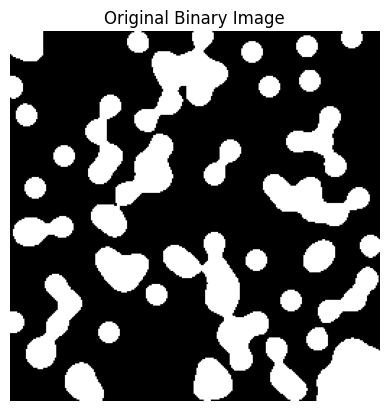

In [74]:
#Wygeneruj syntetyczny obraz binarny o losowych kształtach
image = binary_blobs(length=256, blob_size_fraction=0.1, n_dim=2, volume_fraction=0.3, rng = 0)

# Wyświetl obraz
plt.imshow(image, cmap='gray')
plt.title("Original Binary Image")
plt.axis('off')
plt.show()

# 2. Dylacja i Erozja

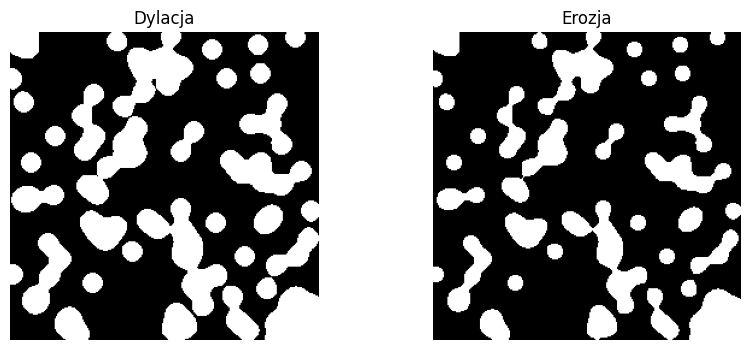

In [75]:
# Zastosuj dylację – rozszerzenie obiektów
dilated = binary_dilation(image)

# Zastosuj erozję – skurczenie obiektów
eroded = binary_erosion(image)

# Wyświetl efekty obok siebie
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(dilated, cmap='gray')
axes[0].set_title("Dylacja")  # Rozrost obiektów
axes[1].imshow(eroded, cmap='gray')
axes[1].set_title("Erozja")  # Skurczenie obiektów
for ax in axes:
    ax.axis('off')
plt.show()

# 3. Otwarcie i Zamknięcie

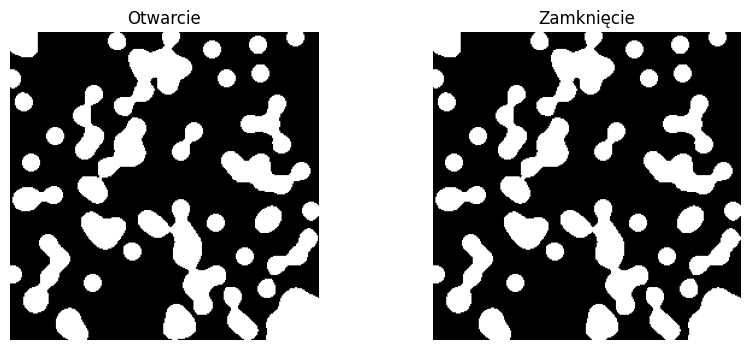

In [76]:
# Otwarcie: erozja + dylacja — usuwa drobne obiekty
opened = binary_opening(image)

# Zamknięcie: dylacja + erozja — wypełnia małe dziury
closed = binary_closing(image)

# Wyświetl wyniki
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(opened, cmap='gray')
axes[0].set_title("Otwarcie")
axes[1].imshow(closed, cmap='gray')
axes[1].set_title("Zamknięcie")
for ax in axes:
    ax.axis('off')
plt.show()

# 4. Granice obiektu

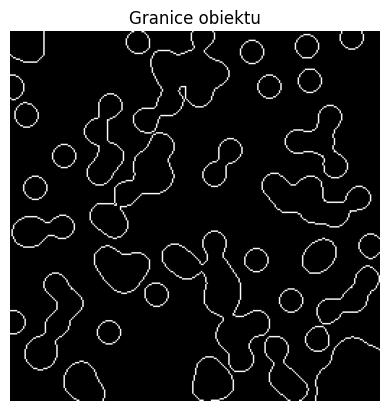

In [77]:
# Wyodrębnij zewnętrzne granice obiektów
boundaries = find_boundaries(image, mode='outer')

# Wyświetl granice
plt.imshow(boundaries, cmap='gray')
plt.title("Granice obiektu")
plt.axis('off')
plt.show()

# 5. Szkielet (Skeletonization)

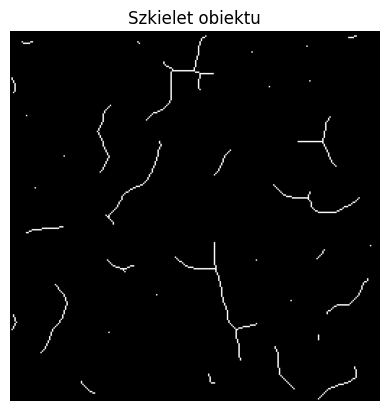

In [78]:
# Wygeneruj szkielet binarny obiektu (linia przechodząca przez środek)
skeleton = skeletonize(image)

# Wyświetl szkielet
plt.imshow(skeleton, cmap='gray')
plt.title("Szkielet obiektu")
plt.axis('off')
plt.show()

# 6. Ścienianie (Thinning)

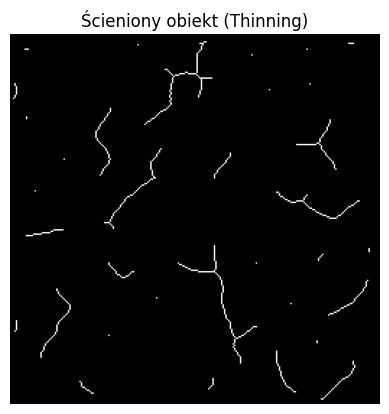

In [79]:
# Zastosuj operację ścieniania — zmniejsza grubość obiektów do jednej linii
thinned = thin(image)

# Wyświetl wynik
plt.imshow(thinned, cmap='gray')
plt.title("Ścieniony obiekt (Thinning)")
plt.axis('off')
plt.show()

# 7. Pogrubianie (Thickening) – symulacja

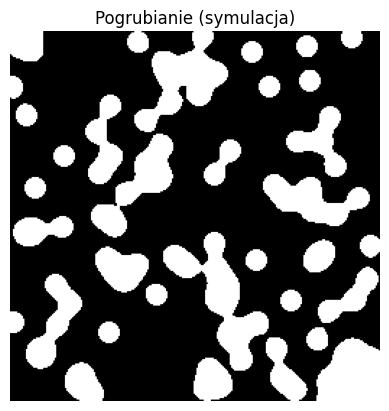

In [80]:
# Symulacja pogrubiania: dodanie pikseli przez logikę OR z dylacją
thickened = image #image OR hit and miss not dilatation

# Wyświetl efekt pogrubienia
plt.imshow(thickened, cmap='gray')
plt.title("Pogrubianie (symulacja)")
plt.axis('off')
plt.show()

# 9. Operacja Hit-or-Miss – wykrywanie wzorców

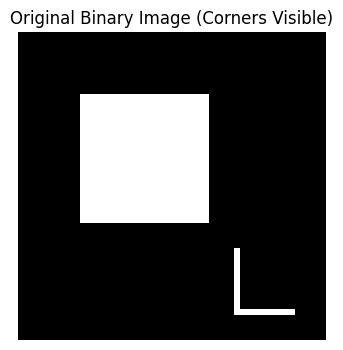

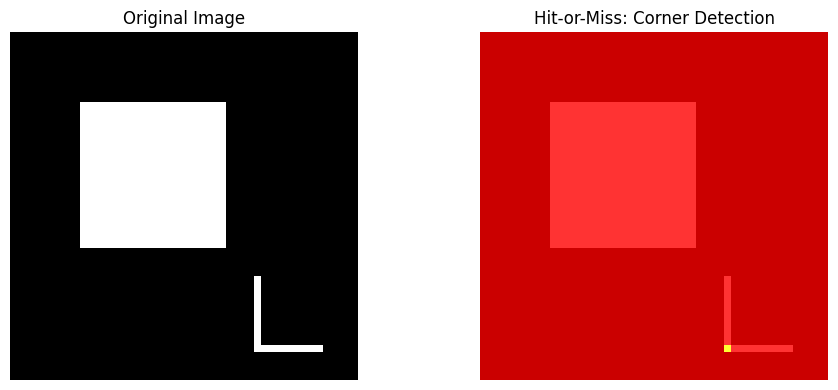

In [81]:
# ===============================================
# Import wymaganych bibliotek
# ===============================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_hit_or_miss
from skimage.draw import rectangle

# ===============================================
# 1. Tworzymy obraz testowy z wyraźnymi narożnikami
# ===============================================

# Pusty obraz binarny
image = np.zeros((50, 50), dtype=bool)

# Dodajemy kwadrat – wyraźne cztery rogi
rr, cc = rectangle(start=(10, 10), end=(30, 30))
image[rr, cc] = True

# Dodajemy literę "L" w prawym dolnym rogu
image[35:45, 35] = True  # pionowa kreska
image[45, 35:45] = True  # pozioma kreska

# Wyświetlamy oryginalny obraz
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.title("Original Binary Image (Corners Visible)")
plt.axis('off')
plt.show()

# ===============================================
# 2. Definiujemy wzorce (elementy strukturalne)
# ===============================================

# Operacja Hit-or-Miss wykrywa określony układ pikseli.
# Poniżej definiujemy wzorce dla 4 typów rogów ("L" w różnych orientacjach).

# Narożnik górny-lewy
se_tl_1 = np.array([[0, 0, 0],
                    [0, 1, 1],
                    [0, 1, 0]])
se_tl_2 = np.array([[1, 1, 1],
                    [1, 0, 0],
                    [1, 0, 1]])

# Narożnik górny-prawy
se_tr_1 = np.rot90(se_tl_1, 1)
se_tr_2 = np.rot90(se_tl_2, 1)

# Narożnik dolny-prawy
se_br_1 = np.rot90(se_tl_1, 2)
se_br_2 = np.rot90(se_tl_2, 2)

# Narożnik dolny-lewy
se_bl_1 = np.rot90(se_tl_1, 3)
se_bl_2 = np.rot90(se_tl_2, 3)

# ===============================================
# 3. Wykonujemy operacje Hit-or-Miss dla każdego wzorca
# ===============================================

hit_tl = binary_hit_or_miss(image, structure1=se_tl_1, structure2=se_tl_2)
hit_tr = binary_hit_or_miss(image, structure1=se_tr_1, structure2=se_tr_2)
hit_br = binary_hit_or_miss(image, structure1=se_br_1, structure2=se_br_2)
hit_bl = binary_hit_or_miss(image, structure1=se_bl_1, structure2=se_bl_2)

# Sumujemy wszystkie wyniki, aby uzyskać pełną mapę narożników
corners = hit_tl | hit_tr | hit_br | hit_bl

# ===============================================
# 4. Wizualizacja wyników
# ===============================================

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Obraz oryginalny
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

# Obraz z wykrytymi narożnikami (nałożone czerwone punkty)
axs[1].imshow(image, cmap='gray')
axs[1].imshow(corners, cmap='autumn', alpha=0.8)
axs[1].set_title("Hit-or-Miss: Corner Detection")
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Dlaczego widzisz żółty punkt tylko w jednym miejscu (na literze “L”), mimo że kwadrat też ma przecież rogi?

# Hit and miss: Poprawiony kod – działa na wszystkich rogach

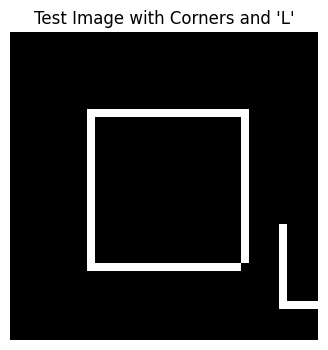

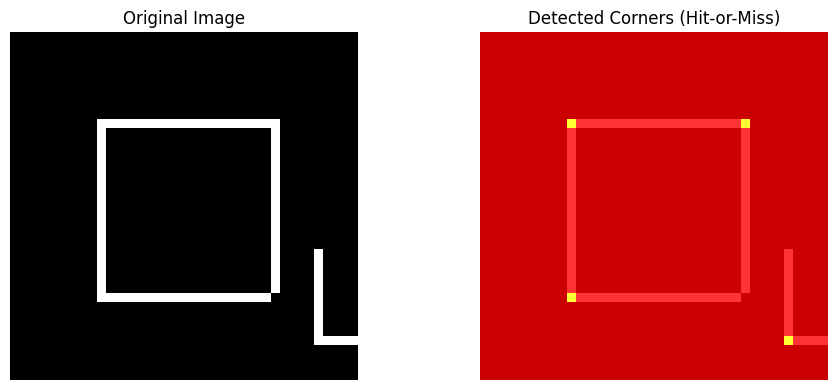

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_hit_or_miss

# ===============================================
# 1. Tworzymy obraz z ramką (pusty kwadrat)
# ===============================================

image = np.zeros((40, 40), dtype=bool)

# Ramka kwadratu
image[10, 10:30] = True   # górna krawędź
image[30, 10:30] = True   # dolna krawędź
image[10:30, 10] = True   # lewa krawędź
image[10:30, 30] = True   # prawa krawędź

# Dodajemy literę "L" w prawym dolnym rogu dla porównania
image[25:35, 35] = True   # pionowa kreska
image[35, 35:45] = True   # pozioma kreska

plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.title("Test Image with Corners and 'L'")
plt.axis('off')
plt.show()

# ===============================================
# 2. Definicje wzorców narożników "L"
# ===============================================

# Narożnik górny-lewy
se_tl_1 = np.array([[0, 0, 0],
                    [0, 1, 1],
                    [0, 1, 0]])
se_tl_2 = np.array([[1, 1, 1],
                    [1, 0, 0],
                    [1, 0, 1]])

# Obracamy wzorce w 4 kierunki
se_tr_1 = np.rot90(se_tl_1, 1); se_tr_2 = np.rot90(se_tl_2, 1)
se_br_1 = np.rot90(se_tl_1, 2); se_br_2 = np.rot90(se_tl_2, 2)
se_bl_1 = np.rot90(se_tl_1, 3); se_bl_2 = np.rot90(se_tl_2, 3)

# ===============================================
# 3. Wykrywanie rogów w 4 kierunkach
# ===============================================

hit_tl = binary_hit_or_miss(image, structure1=se_tl_1, structure2=se_tl_2)
hit_tr = binary_hit_or_miss(image, structure1=se_tr_1, structure2=se_tr_2)
hit_br = binary_hit_or_miss(image, structure1=se_br_1, structure2=se_br_2)
hit_bl = binary_hit_or_miss(image, structure1=se_bl_1, structure2=se_bl_2)

# Sumujemy wyniki z różnych kierunków
corners = hit_tl | hit_tr | hit_br | hit_bl

# ===============================================
# 4. Wizualizacja wyników
# ===============================================

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(image, cmap='gray')
axs[1].imshow(corners, cmap='autumn', alpha=0.8)
axs[1].set_title("Detected Corners (Hit-or-Miss)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

# 10. Wypukła otoczka (Convex Hull)

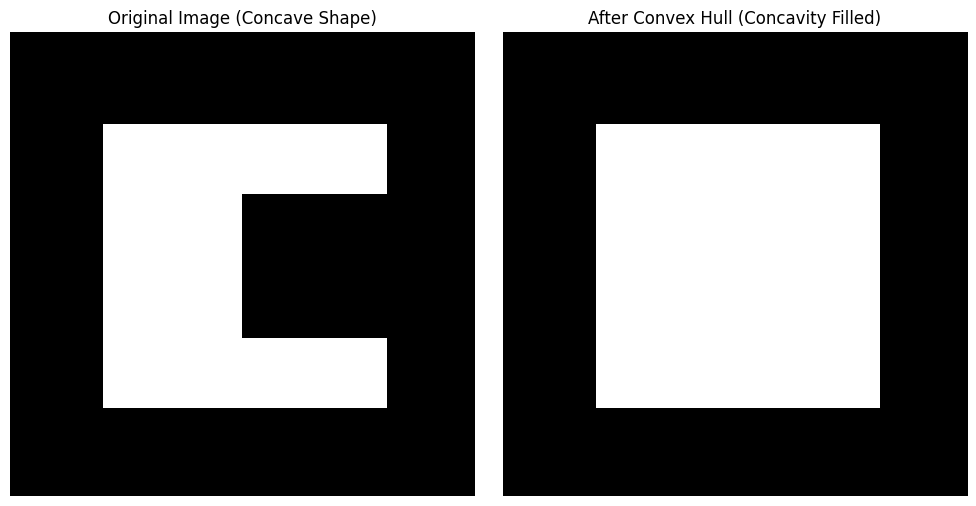

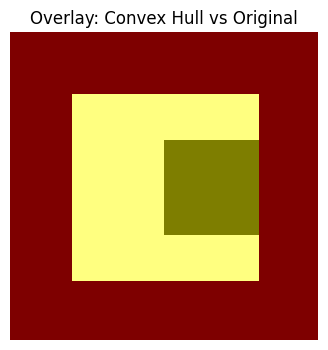

In [83]:
# Import wymaganych bibliotek
import numpy as np                      # Do pracy na tablicach numerycznych
import matplotlib.pyplot as plt          # Do wizualizacji wyników
from skimage.morphology import convex_hull_image  # Funkcja do obliczania wypukłej otoczki
from skimage.draw import rectangle       # Pomoc do rysowania prostokątów

# ===============================================
# 1. Tworzymy obraz testowy – obiekt z wklęsłością
# ===============================================

# Tworzymy pusty obraz 100x100 pikseli (czarne tło)
image = np.zeros((100, 100), dtype=bool)

# Dodajemy duży biały prostokąt – główne ciało obiektu
rr, cc = rectangle(start=(20, 20), end=(80, 80))
image[rr, cc] = True

# Wycinamy fragment środka, żeby powstała "wklęsłość" – np. litera "C"
rr_hole, cc_hole = rectangle(start=(35, 50), end=(65, 80))
image[rr_hole, cc_hole] = False

# ===============================================
# 2. Obliczamy wypukłą otoczkę (Convex Hull)
# ===============================================

# Funkcja convex_hull_image() zwraca najmniejszy wypukły kształt,
# który całkowicie obejmuje obiekt wejściowy.
convex_hull = convex_hull_image(image)

# ===============================================
# 3. Wizualizacja wyniku
# ===============================================

# Tworzymy dwa obrazy obok siebie: oryginał i jego otoczkę
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# (a) Obraz oryginalny
axs[0].imshow(image, cmap='gray')
axs[0].set_title("Original Image (Concave Shape)")  # Widać „wklęsłość”
axs[0].axis('off')

# (b) Obraz po zastosowaniu Convex Hull
axs[1].imshow(convex_hull, cmap='gray')
axs[1].set_title("After Convex Hull (Concavity Filled)")  # Wklęsłość została wypełniona
axs[1].axis('off')

plt.tight_layout()
plt.show()

# ===============================================
# 4. Analiza wyniku
# ===============================================

# Dla lepszej wizualizacji różnic — nałóżmy wynik otoczki na oryginał
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')               # oryginał jako tło
plt.imshow(convex_hull, cmap='autumn', alpha=0.5)  # otoczka w półprzezroczystym kolorze
plt.title("Overlay: Convex Hull vs Original")
plt.axis('off')
plt.show()

# Zadanie 1. Analiza mikroskopowego obrazu komórek / ziaren pyłku

Celem zadania jest przećwiczenie podstawowych operacji morfologicznych na realistycznym obrazie mikroskopowym komórek, w tym:

* poprawy kontrastu,
* ręcznego progowania,
* filtracji szumów i wypełniania obiektów,
* wyodrębnienia granic komórek.

Student powinien zrozumieć, jak kolejne kroki przetwarzania obrazu wpływają na jakość segmentacji.

Opis zadania

Używając biblioteki scikit-image, wykonaj kompletny proces segmentacji komórek z przykładowego obrazu mikroskopowego data.cells3d().


---

## 1. Wczytanie obrazu mikroskopowego:

* **Użyj danych wbudowanych w skimage.data.cells3d().**
* **Wybierz jeden kanał (np. jądrowy) i jedną warstwę obrazu 3D.**

Funkcja skimage.data.cells3d() zwraca trójwymiarowy obraz mikroskopowy komórek (3D image stack), pochodzący z mikroskopii konfokalnej.
Dane te są dostępne w bibliotece scikit-image jako przykładowy zestaw danych biologicznych.

Obraz ma cztery wymiary: shape = (Z, Channels, Y, X)

czyli:

Z – liczba warstw (głębokość, kolejne przekroje 3D),
Channels – różne kanały barwne / fluorescencyjne (np. DNA, błony komórkowe),
Y – wysokość obrazu (liczba wierszy),
X – szerokość obrazu (liczba kolumn).

Co robi linijka: image_gray = data.cells3d()[:, 1, :, :]
Znaczenie poszczególnych indeksów:

* : → pobiera wszystkie warstwy (Z)
* 1 → wybiera kanał nr 1 (drugi kanał, tzw. nuclear channel)
* :, : → pobiera wszystkie piksele w wymiarach Y i X

Efekt:

Otrzymujemy trójwymiarowy obraz (Z × Y × X) pokazujący rozkład fluorescencji jądrowej komórek.

Dlaczego kanał 1?

- Kanał 0 w cells3d() odpowiada barwieniu błon komórkowych,
- Kanał 1 – barwieniu jąder komórkowych (DNA),
czyli tego, co najczęściej analizujemy w segmentacji biologicznej.

image_gray = image_gray[30]
Ten krok wybiera jedną warstwę (Z-slice) z trójwymiarowego stosu obrazów. Wartość 30 to po prostu numer przekroju (można użyć innego, np. 10, 20, 40...). Wynikiem jest obraz 2D, który można łatwo wyświetlić i analizować za pomocą morfologii.

* **Wyświetl obraz w skali szarości.**

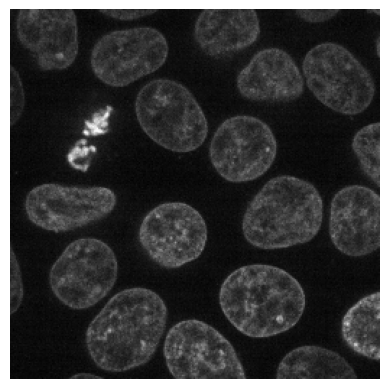

In [84]:
cells = cells3d()[30, 1, :, :]

plt.imshow(cells, "gray")
plt.axis("off")
plt.show()

## 2. Poprawa Kontrastu

Użyj funkcji exposure.equalize_hist() w celu wyrównania histogramu jasności.

* Porównaj obraz przed i po poprawie kontrastu.
* Wyjaśnij, dlaczego ten krok ułatwia dalsze progowanie.



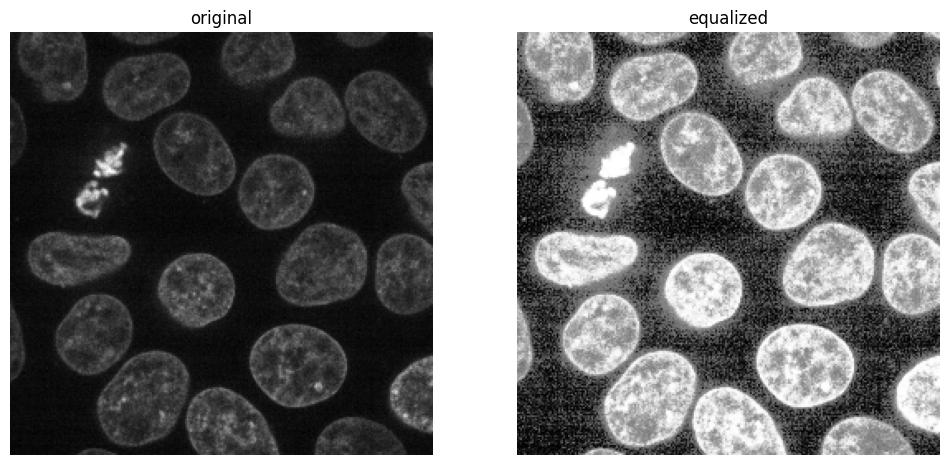

In [85]:
equalized = equalize_hist(cells)

show_row([cells, equalized], ["original", "equalized"])

Krok ten wyraźnie wyróżnia komórki, co ułatwia oddzielenie ich od tła.

## 3. Ręczne progowanie

* Dobierz ręcznie wartość progu (threshold_value), np. 0.3–0.5.
* Zastosuj maskę binarną, gdzie True odpowiada obiektom (komórkom).
* Zbadaj, jak zmiana progu wpływa na liczbę i kształt wykrytych komórek.

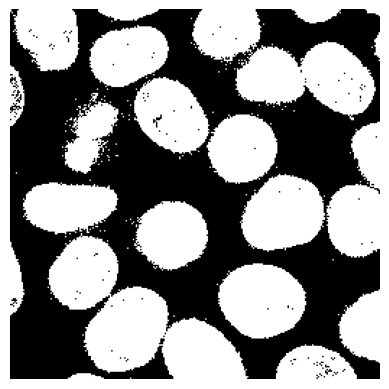

In [86]:
binary_cells = np.where(equalized>0.5, 1, 0) 

show_image(binary_cells)

## 4.Otwarcie morfologiczne (Opening)

* Użyj morphology.binary_opening() z elementem strukturalnym disk(2).
* Usuń drobny szum i małe artefakty z binarnego obrazu.
* Zobrazuj efekt tej operacji.

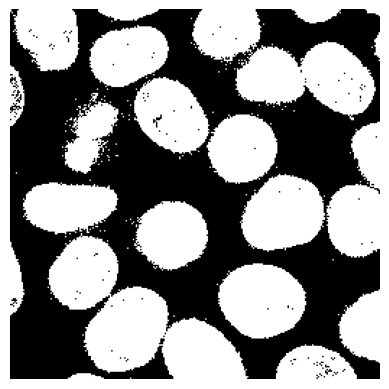

In [87]:
binary_cells_opened = binary_opening(binary_cells, disk(2))

show_image(binary_cells)

## 5.Zamknięcie morfologiczne (Closing)

* Zastosuj morphology.binary_closing() z elementem disk(3).
* Wypełnij małe dziury wewnątrz komórek i wygładź ich krawędzie.
* Porównaj wynik z obrazem po otwarciu.

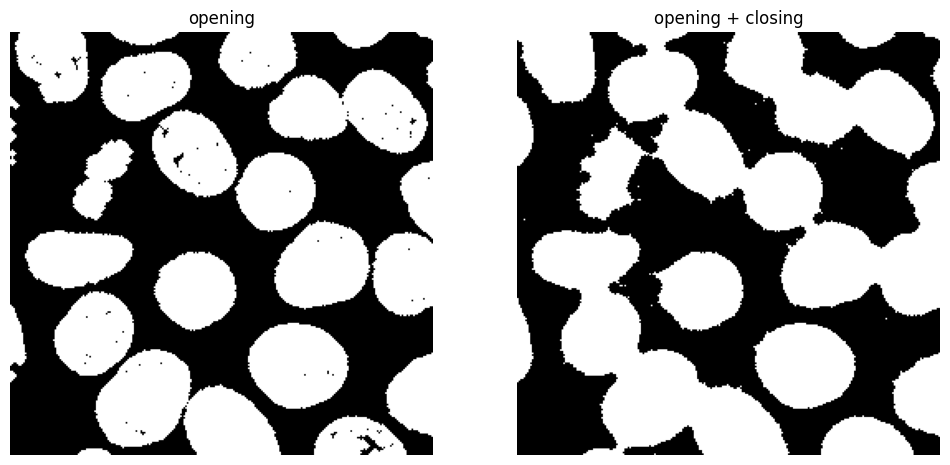

In [88]:
binary_cells_closed = binary_closing(binary_cells, disk(3))

show_row([binary_cells_opened, binary_cells_closed], ["opening", "opening + closing"])

## 6.Wyodrębnienie granic komórek

* Użyj segmentation.find_boundaries() do detekcji krawędzi obiektów.
* Nałóż kontury komórek na obraz w skali szarości, aby zwizualizować efekt segmentacji.
* Wizualizacja etapów przetwarzania
* Utwórz zestawienie wszystkich etapów w postaci siatki obrazów (2×3).
* Dodaj tytuły dla każdego etapu, np.:

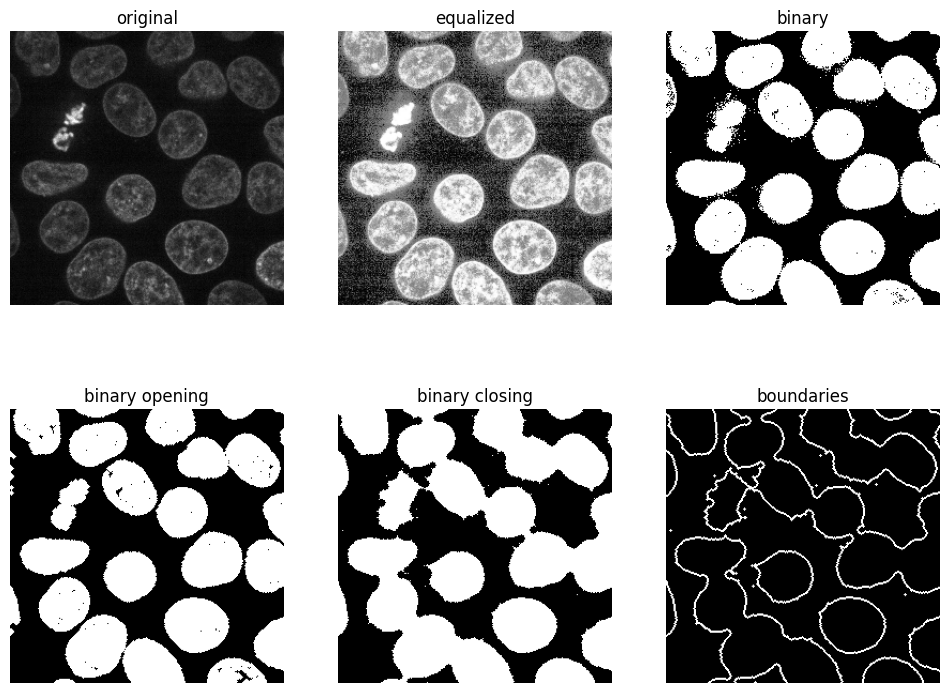

In [89]:
boundaries = find_boundaries(binary_cells_closed)

show_matrix([[cells, equalized, binary_cells], 
             [binary_cells_opened, binary_cells_closed, boundaries]],
             [["original", "equalized", "binary"], 
             ["binary opening", "binary closing", "boundaries"]])

# Zadanie 2. Analiza kształtu obiektów z użyciem wypukłej otoczki (Convex Hull)
Celem zadania jest zrozumienie działania operacji wypukłej otoczki (Convex Hull) i jej wykorzystania do:

* opisu kształtu obiektów,
* wykrywania wklęsłości,
* porównania rzeczywistego kształtu z jego wypukłym przybliżeniem.

Student nauczy się, jak zastosować Convex Hull do prostych analiz geometrycznych na obrazach binarnych.


---



Opis problemu

Dany jest obraz przedstawiający obiekty o nieregularnych kształtach (np. komórki, ziarna piasku lub krople cieczy).
Celem jest:

* Oczyszczenie obrazu,
* Zastosowanie operacji Convex Hull dla każdego obiektu,
* Porównanie oryginalnych kształtów z ich otoczkami,
* Obliczenie miary „wklęsłości” obiektu, czyli różnicy między jego polem a polem jego wypukłej otoczki.


---

## 1. Wczytanie obrazu

* Użyj wbudowanego obrazu skimage.data.coins() lub własnego binarnego zdjęcia z wyraźnymi obiektami (np. nasionami, liśćmi, pęcherzykami).
* Jeśli obraz jest w skali szarości – przekształć go w binarny przez progowanie.

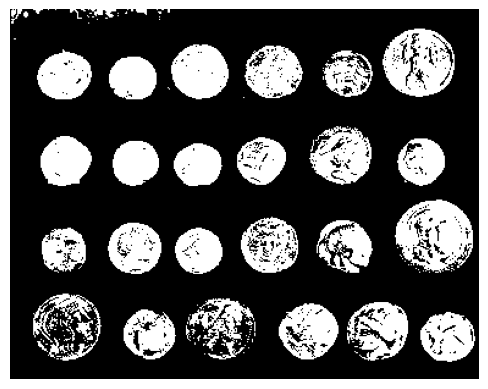

In [144]:
THRESHOLD = 0.73
binary_coins = np.where(equalize_hist(coins())>THRESHOLD, 1, 0)
show_image(binary_coins)

## 2.Czyszczenie obrazu

* Usuń drobne zakłócenia za pomocą otwarcia i zamknięcia morfologicznego.

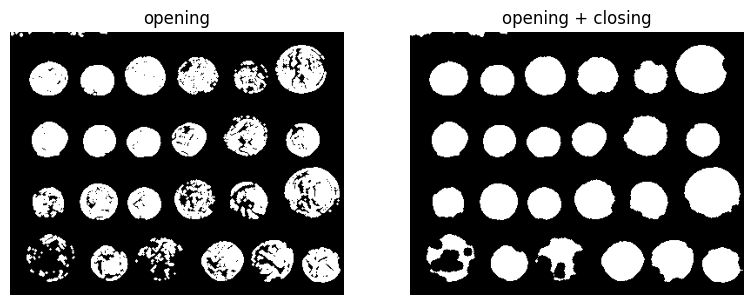

In [105]:
opened_coins = binary_opening(binary_coins, disk(1))
clean_coins = binary_closing(opened_coins, disk(5))
show_row([opened_coins, clean_coins], ["opening", "opening + closing"])

## 3.Wykorzystanie Convex Hull 

* Dla każdego obiektu (etykiety) oblicz jego wypukłą otoczkę.
* Porównaj oryginalny kształt i jego wypukłe przybliżenie.

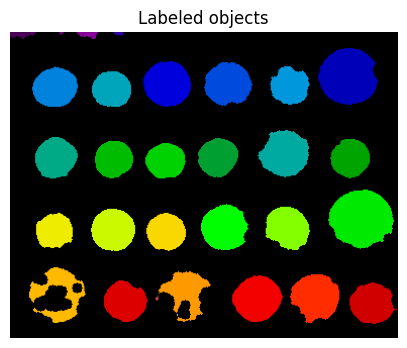

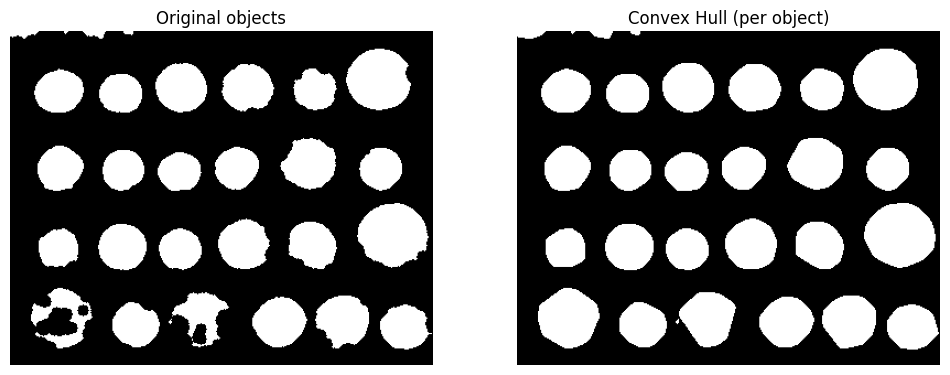

In [106]:
#Etykietowanie obiektów
# do poniższego fragmentu zadania:
# Zastosowanie operacji Convex Hull dla każdego obiektu,
# Porównanie oryginalnych kształtów z ich otoczkami,

# Każdy spójny obiekt dostaje unikalną etykietę (1..N), tło = 0
labeled = label(clean_coins)

plt.figure(figsize=(5, 5))
plt.imshow(labeled, cmap='nipy_spectral')
plt.title("Labeled objects")
plt.axis('off')
plt.show()

# Convex Hull dla KAŻDEGO obiektu
# Globalna maska na złożone otoczki wypukłe
convex_mask = np.zeros_like(clean_coins, dtype=bool)

# Dla każdego regionu (obiekt w jego bbox) liczmy otoczkę wypukłą
for region in regionprops(labeled):
    obj_img = region.image # wycięty obiekt (maską) w obrębie bbox
    hull = convex_hull_image(obj_img) # wypukła otoczka tego obiektu
    minr, minc, maxr, maxc = region.bbox # pozycja bbox w obrazie globalnym
    convex_mask[minr:maxr, minc:maxc] |= hull # wklejamy hull na właściwe miejsce

# Podgląd: oryginalne obiekty vs convex hull
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(clean_coins, cmap='gray'); axes[0].set_title("Original objects")
axes[1].imshow(convex_mask, cmap='gray'); axes[1].set_title("Convex Hull (per object)")
for ax in axes: ax.axis('off')
plt.show()


## 4.Obliczenie miary wklęsłości

* Dla każdego obiektu oblicz:
* pole oryginalnego obiektu,
* pole jego wypukłej otoczki,
* stosunek Concavity = (A_hull - A_object) / A_hull.

In [107]:
for region in regionprops(labeled):
    minr, minc, maxr, maxc = region.bbox
    y = int(minr + maxr)/2
    x = int(minc + maxc)/2
    print(f"Label: {region.label}, x: {x}, y: {y}")

    print(f"  Area of the coin: {region.area}")
    print(f"  Area of the convex hull: {region.area_convex}", )
    print(f"  Concavity: {(region.area_convex - region.area)/region.area_convex:.4f}")

Label: 1, x: 13.0, y: 3.5
  Area of the coin: 116.0
  Area of the convex hull: 144.0
  Concavity: 0.1944
Label: 2, x: 51.0, y: 1.5
  Area of the coin: 8.0
  Area of the convex hull: 8.0
  Concavity: 0.0000
Label: 3, x: 76.5, y: 3.5
  Area of the coin: 94.0
  Area of the convex hull: 108.0
  Concavity: 0.1296
Label: 4, x: 107.5, y: 2.0
  Area of the coin: 27.0
  Area of the convex hull: 30.0
  Concavity: 0.1000
Label: 5, x: 334.5, y: 44.0
  Area of the coin: 2524.0
  Area of the convex hull: 2607.0
  Concavity: 0.0318
Label: 6, x: 155.5, y: 51.5
  Area of the coin: 1638.0
  Area of the convex hull: 1676.0
  Concavity: 0.0227
Label: 7, x: 216.0, y: 51.5
  Area of the coin: 1548.0
  Area of the convex hull: 1609.0
  Concavity: 0.0379
Label: 8, x: 44.5, y: 54.0
  Area of the coin: 1360.0
  Area of the convex hull: 1401.0
  Concavity: 0.0293
Label: 9, x: 277.0, y: 53.0
  Area of the coin: 1106.0
  Area of the convex hull: 1190.0
  Concavity: 0.0706
Label: 10, x: 100.5, y: 56.5
  Area of the

## 5.Wizualizacja różnic (różnica pomiędzy obiektem a otoczką)

* Wyświetl piksele, które należą do otoczki, ale nie do oryginalnego obiektu (czyli „wklęsłe fragmenty”).

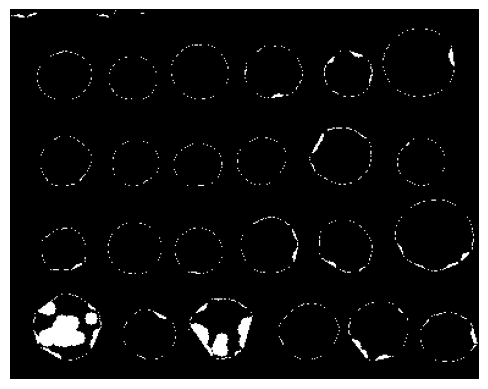

In [108]:
labeled = label(clean_coins)
fill = np.zeros_like(clean_coins, dtype=bool)

for region in regionprops(labeled):
    obj_img = region.image 
    hull = convex_hull_image(obj_img) 
    minr, minc, maxr, maxc = region.bbox
    fill[minr:maxr, minc:maxc] = hull & ~region.image

show_image(fill)

## Adaptive thresholding

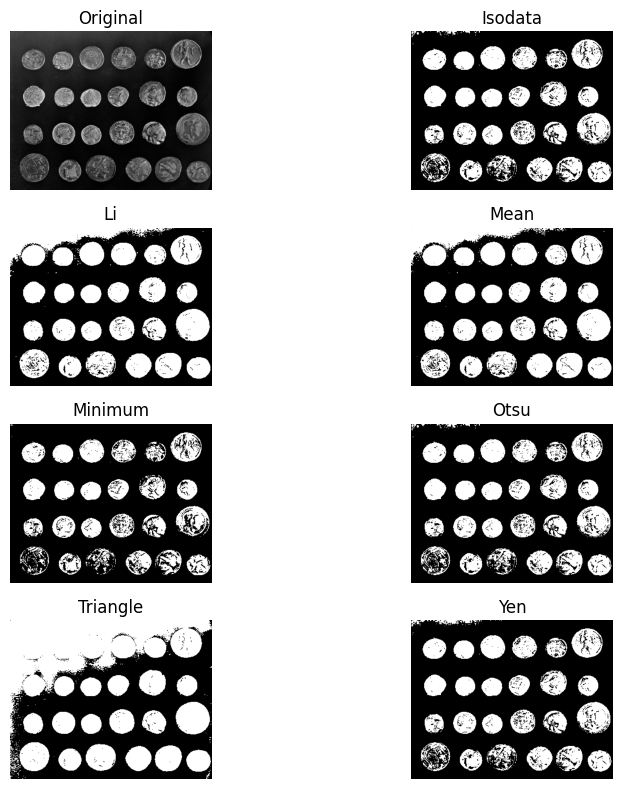

In [308]:
GAMMA = 2
gamma_coins = adjust_gamma(coins(), GAMMA)

fig, ax = try_all_threshold(gamma_coins, figsize=(10, 8), verbose=False)

plt.show()

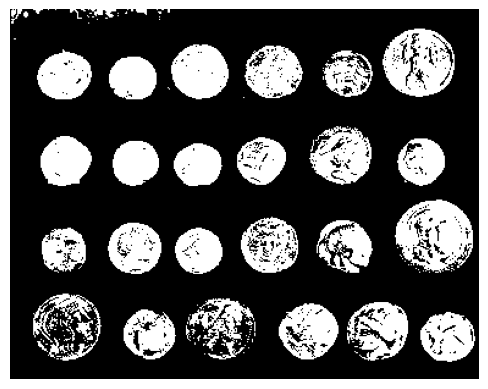

In [309]:
thresholding_function = threshold_otsu
ada_binary_coins = gamma_coins > thresholding_function(gamma_coins)
show_image(ada_binary_coins)

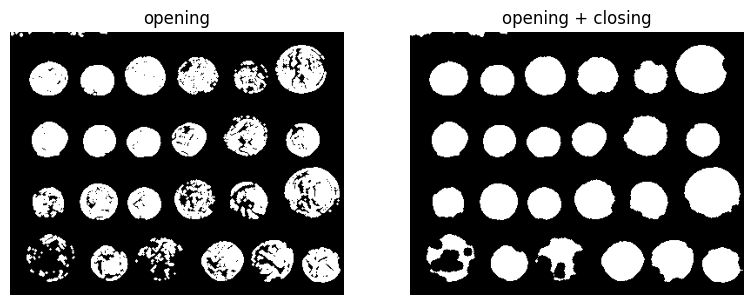

In [310]:
ada_opened_coins = binary_opening(ada_binary_coins, disk(1))
ada_clean_coins = binary_closing(ada_opened_coins, disk(5))
show_row([ada_opened_coins, ada_clean_coins], ["opening", "opening + closing"])

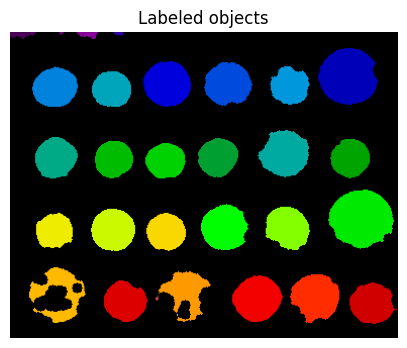

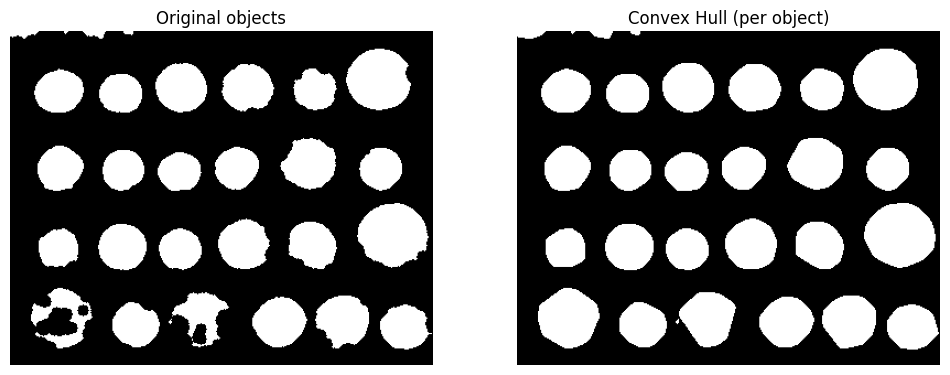

In [311]:
#Etykietowanie obiektów
# do poniższego fragmentu zadania:
# Zastosowanie operacji Convex Hull dla każdego obiektu,
# Porównanie oryginalnych kształtów z ich otoczkami,

# Każdy spójny obiekt dostaje unikalną etykietę (1..N), tło = 0
labeled = label(ada_clean_coins)

plt.figure(figsize=(5, 5))
plt.imshow(labeled, cmap='nipy_spectral')
plt.title("Labeled objects")
plt.axis('off')
plt.show()

# Convex Hull dla KAŻDEGO obiektu
# Globalna maska na złożone otoczki wypukłe
ada_convex_mask = np.zeros_like(ada_clean_coins, dtype=bool)

# Dla każdego regionu (obiekt w jego bbox) liczmy otoczkę wypukłą
for region in regionprops(labeled):
    obj_img = region.image # wycięty obiekt (maską) w obrębie bbox
    hull = convex_hull_image(obj_img) # wypukła otoczka tego obiektu
    minr, minc, maxr, maxc = region.bbox # pozycja bbox w obrazie globalnym
    ada_convex_mask[minr:maxr, minc:maxc] |= hull # wklejamy hull na właściwe miejsce

# Podgląd: oryginalne obiekty vs convex hull
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(ada_clean_coins, cmap='gray'); axes[0].set_title("Original objects")
axes[1].imshow(ada_convex_mask, cmap='gray'); axes[1].set_title("Convex Hull (per object)")
for ax in axes: ax.axis('off')
plt.show()

In [312]:
for region in regionprops(labeled):
    minr, minc, maxr, maxc = region.bbox
    y = int(minr + maxr)/2
    x = int(minc + maxc)/2
    print(f"Label: {region.label}, x: {x}, y: {y}")

    print(f"  Area of the coin: {region.area}")
    print(f"  Area of the convex hull: {region.area_convex}", )
    print(f"  Concavity: {(region.area_convex - region.area)/region.area_convex:.4f}")

Label: 1, x: 13.0, y: 3.5
  Area of the coin: 116.0
  Area of the convex hull: 144.0
  Concavity: 0.1944
Label: 2, x: 51.0, y: 1.5
  Area of the coin: 8.0
  Area of the convex hull: 8.0
  Concavity: 0.0000
Label: 3, x: 76.5, y: 3.5
  Area of the coin: 94.0
  Area of the convex hull: 108.0
  Concavity: 0.1296
Label: 4, x: 107.5, y: 2.0
  Area of the coin: 27.0
  Area of the convex hull: 30.0
  Concavity: 0.1000
Label: 5, x: 334.5, y: 44.0
  Area of the coin: 2524.0
  Area of the convex hull: 2607.0
  Concavity: 0.0318
Label: 6, x: 155.5, y: 51.5
  Area of the coin: 1638.0
  Area of the convex hull: 1676.0
  Concavity: 0.0227
Label: 7, x: 216.0, y: 51.5
  Area of the coin: 1548.0
  Area of the convex hull: 1609.0
  Concavity: 0.0379
Label: 8, x: 44.5, y: 54.0
  Area of the coin: 1360.0
  Area of the convex hull: 1401.0
  Concavity: 0.0293
Label: 9, x: 277.0, y: 53.0
  Area of the coin: 1106.0
  Area of the convex hull: 1190.0
  Concavity: 0.0706
Label: 10, x: 100.5, y: 56.5
  Area of the

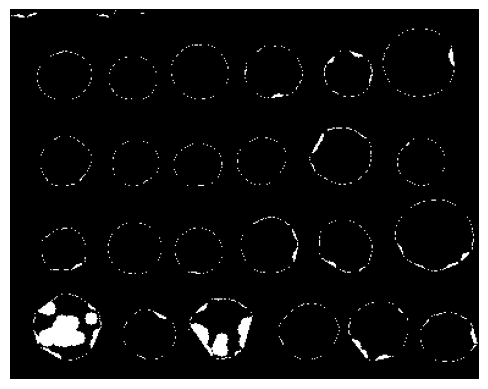

In [313]:
labeled = label(ada_clean_coins)
ada_fill = np.zeros_like(ada_clean_coins, dtype=bool)

for region in regionprops(labeled):
    obj_img = region.image 
    hull = convex_hull_image(obj_img) 
    minr, minc, maxr, maxc = region.bbox
    ada_fill[minr:maxr, minc:maxc] = hull & ~region.image

show_image(ada_fill)

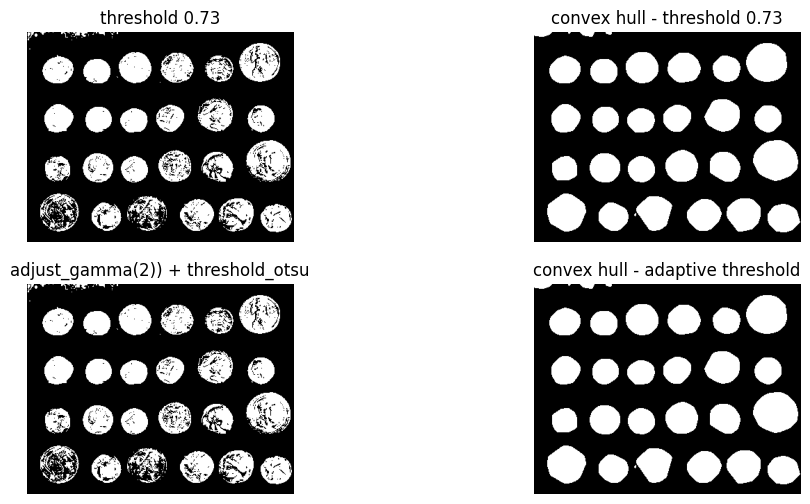

In [314]:
show_matrix([[binary_coins, convex_mask],[ada_binary_coins, ada_convex_mask]],
            [[f"threshold {THRESHOLD}", f"convex hull - threshold {THRESHOLD}"],
             [f"adjust_gamma({GAMMA})) + {thresholding_function.__name__}",
              f"convex hull - adaptive threshold"]])

In [333]:
diff = convex_mask != ada_convex_mask
diff = diff[diff==True]
if diff.shape == (0,):
    print("Udało się osiągnąć te same wyniki")
else:
    print("Wyniki różnią się")

Udało się osiągnąć te same wyniki
